# Taxi Demand Prediction

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%cd ..
import common
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import clustering
import plotting
import pandas as pd
from IPython.display import IFrame

# Seaborn properties
sns.set_context("poster", font_scale=1.5)

/home/wallar/projects/nyc-taxi-analysis


ImportError: No module named common

## Loading Trip Data

In [4]:
n_rows = 100000
df = common.load_data(nrows=n_rows)

Executing: load_data
With Args: None
With Kwargs: 
	nrows : 100000
Result: <class 'pandas.core.frame.DataFrame'>
Execution Duration: 6.28613400459 seconds



## Loading NYC Road Network

In [7]:
import networkx as nx
import tqdm


def time_names(name):
    return ["id"] + [name + "_%d" % i for i in xrange(24)]


NYC_DIR = "data/nyc-graph/{}.csv"
nyc_edges = pd.read_csv(NYC_DIR.format("edges"), names=["id", "source", "sink"])
nyc_nodes = pd.read_csv(NYC_DIR.format("points"), names=["id", "lat", "lon"])
nyc_week_times = pd.read_csv(NYC_DIR.format("week"), names=time_names("week"))
nyc_sat_times = pd.read_csv(NYC_DIR.format("sat"), names=time_names("sat"))
nyc_sun_times = pd.read_csv(NYC_DIR.format("sun"), names=time_names("sun"))
nyc_graph = nx.DiGraph()
n_edges = nyc_edges.shape[0]
rng = tqdm.tqdm_notebook(nyc_edges.iterrows(), total=n_edges)

for i, edge in rng:
    src = edge["source"] - 1
    sink = edge["sink"] - 1
    src_pos = np.array([nyc_nodes.iloc[src]["lon"],
                        nyc_nodes.iloc[src]["lat"]])
    sink_pos = np.array([nyc_nodes.iloc[sink]["lon"],
                         nyc_nodes.iloc[sink]["lat"]])
    weights = nyc_week_times.iloc[i]
    nyc_graph.add_node(src, pos=src_pos)
    nyc_graph.add_node(sink, pos=sink_pos)
    nyc_graph.add_edge(edge["source"], edge["sink"], **weights)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## NYC Station Partitioning

### Finding clusters with maximum travel time tolerance 

In [8]:
import tqdm
import time
import sklearn.neighbors as nn
from scipy.spatial import KDTree


def find_clusters(geos, tol):
    hav_tol = tol / 6371.0
    used = [False] * len(geos)
    ball_tree = nn.BallTree(np.radians(geos), metric="haversine")
    centers = list()
    for i in xrange(len(geos)):
        if not used[i]:
            st = geos[i]
            centers.append(st)
            nearest = ball_tree.query_radius([np.radians(st)], hav_tol)[0]
            for i in nearest:
                used[i] = True
    return np.array(centers)


stations = find_clusters(nyc_nodes.as_matrix(["lon", "lat"]), 0.3)
stations_kd = KDTree(stations)
n_stations = len(stations)
print "Stations:", n_stations

Stations: 202


### Plotting clusters

IOError: [Errno 2] No such file or directory: '../sandbox/nyc.geo.json'

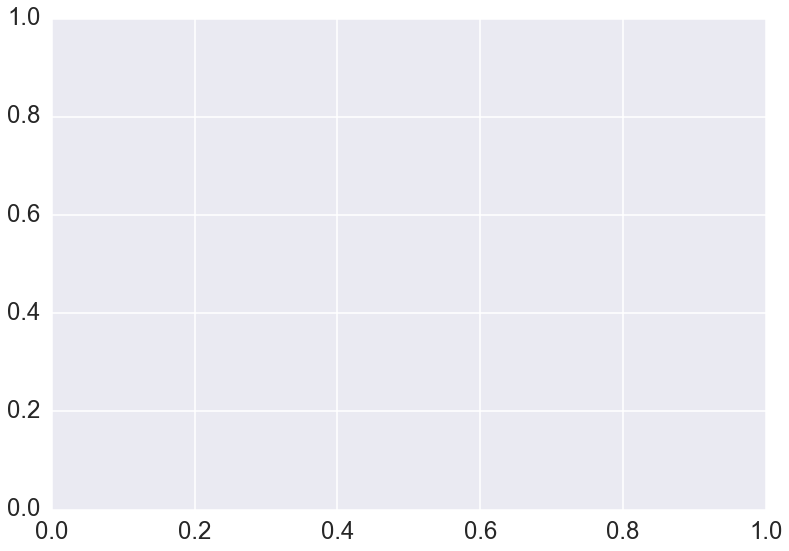

In [10]:
fig, ax = plt.subplots(1, 1)
plotting.plot_manhattan(ax)
ax.scatter(
    stations[:, 0], 
    stations[:, 1],
    s=100, marker="*", label="Stations")
ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_title("Dropoff Station Likelihood Given Pickup Station")

## Determining Pickup -- Dropoff Probabilities
### Finding pickup to dropoff station frequencies

In [15]:
from multiprocessing import Pool


def calc_freqs(rng):
    freqs = np.zeros((n_stations, n_stations))
    for i in tqdm.tqdm(rng, position=0):
        row = df.iloc[i]
        pickup = np.array([row["pickup_longitude"],
                           row["pickup_latitude"]])
        dropoff = np.array([row["dropoff_longitude"],
                            row["dropoff_latitude"]])
        _, p_label = stations_kd.query(pickup)
        _, d_label = stations_kd.query(dropoff)
        freqs[p_label][d_label] += 1
    return freqs


pool = Pool(8)
arrs = np.array_split(range(df.shape[0]), 8)
arrs = map(list, arrs)
freqs = sum(pool.map(calc_freqs, arrs))
#freqs = calc_freqs(arrs[0])
pool.close()

100%|██████████| 10446/10446 [00:05<00:00, 1952.78it/s]


### Determining the pairwise probabilities

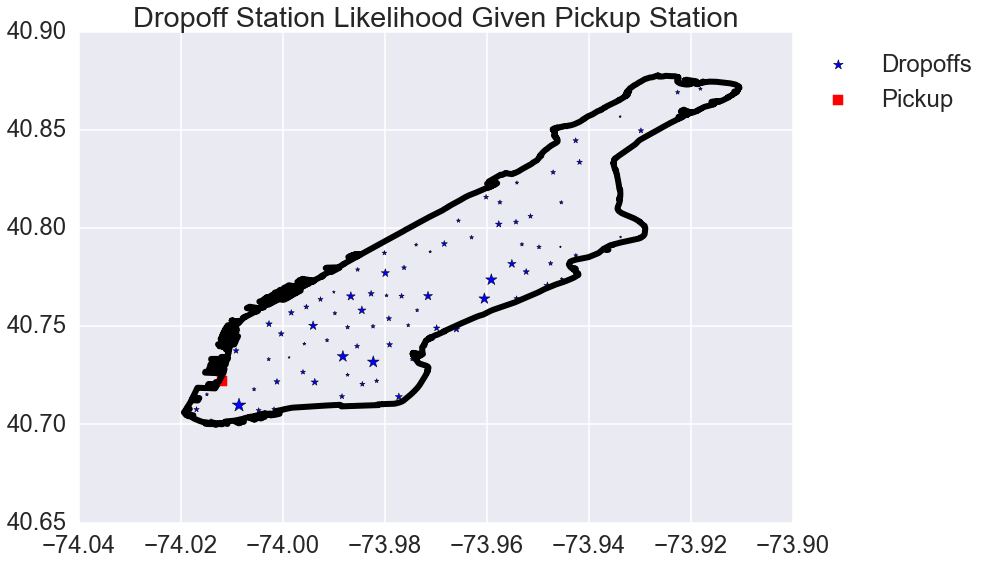

In [52]:
probs = freqs / freqs.sum(axis=0)
interest = 5
fig, ax = plt.subplots(1, 1)
plotting.plot_manhattan(ax)
sizes = probs[interest] * 7000
ax.scatter(
    dropoff_centers[:, 0], 
    dropoff_centers[:, 1],
    s=sizes, marker="*", label="Dropoffs")
ax.scatter(
    pickup_centers[interest, 0],
    pickup_centers[interest, 1],
    marker="s", s=100, color="r", label="Pickup")
ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_title("Dropoff Station Likelihood Given Pickup Station")

## Saving Data

In [82]:
np.savetxt("/home/wallar/www/taxi-vis/probs.csv", probs, delimiter=",",
           header=",".join(str(i) for i in xrange(200)), comments="")
np.savetxt("/home/wallar/www/taxi-vis/pickup_stations.csv", pickup_cls.cluster_centers_, delimiter=",",
           header="lng,lat", comments="")
np.savetxt("/home/wallar/www/taxi-vis/dropoff_stations.csv", dropoff_cls.cluster_centers_, delimiter=",",
           header="lng,lat", comments="")

## Interactive Taxi Demand Map

In [83]:
IFrame("http://wallarelvo-tower.csail.mit.edu/taxi-vis", width=800, height=700)